In [2]:
import sys
import os
import time
sys.path.append(os.path.abspath('../..'))

import gpflow
import tensorflow as tf
from gpflow.optimizers import Scipy

from rcgp.morcgp import MOGPRegressor_NC, MORCGP_shared_noise
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 28,         
    'axes.labelsize': 28,    
    'axes.titlesize': 30,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 5,    
    'lines.markersize': 6   
})

c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

In [4]:
def uniform_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N 
    num_outliers = int(np.round(percent_outliers * total_elements))

    row_indices = np.random.choice(N, num_outliers, replace=False)

    signs = np.random.choice([-1, 1], size=num_outliers)

    uniform_values = np.random.uniform(start, end, size=num_outliers) * signs

    Y_outliers[row_indices, 0] += uniform_values

    return Y_outliers

def asymmetric_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")
    
    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N 
    num_outliers = int(np.round(percent_outliers * total_elements))

    row_indices = np.random.choice(N, num_outliers, replace=False)

    uniform_values = np.random.uniform(start, end, size=num_outliers)

    Y_outliers[row_indices, 0] += uniform_values

    return Y_outliers

def focused_outliers_c1(X, Y, percent_outliers, y_value, perturbation=0.1):
    def mad(X):
        medians = np.median(X, axis=0)
        deviations = np.abs(X - medians)
        return np.median(deviations, axis=0)

    X = X.copy()
    Y = Y.copy()

    n_samples, n_features = X.shape
    n_outliers = int(n_samples * percent_outliers)

    # Indices of outliers
    indices = np.random.choice(n_samples, size=n_outliers, replace=False)

    medians_2d = np.tile(np.median(X, axis=0), (n_outliers, 1))

    def mad(X, axis=0):
        """Compute Median Absolute Deviation (MAD)"""
        med = np.median(X, axis=axis)
        return np.median(np.abs(X - med), axis=axis)

    mads = mad(X)
    mads_2d = np.tile(mads, (n_outliers, 1))

    u = np.random.uniform(0, perturbation, size=medians_2d.shape)
    X_outliers = medians_2d + u * mads_2d

    Y_outliers = np.full(shape=n_outliers, fill_value=y_value)

    first_column = Y[:, 0]
    median_y0 = np.median(first_column)
    mad_y0 = np.median(np.abs(first_column - median_y0))
    Y_mad_outliers = np.full(shape=n_outliers, fill_value=mad_y0)

    # Draw u independently for each element
    u = np.random.uniform(0, perturbation, size=Y_outliers.shape)

    # Compute the perturbed Y_outliers
    Y_outliers_perturbed = Y_outliers + u * Y_mad_outliers

    X[indices, :] = X_outliers
    Y[indices, 0] = Y_outliers_perturbed

    return X, Y

def student_t_outliers(Y, percent_outliers, df=8, scale=5.0):
    Y = Y.copy()

    n_samples = Y.shape[0]
    n_outliers = int(n_samples * percent_outliers)

    indices = np.random.choice(n_samples, size=n_outliers, replace=False)

    t_y_samples = np.random.standard_t(df=df, size=n_outliers) * scale

    Y[indices, 0] += t_y_samples

    return Y

In [5]:
def make_X_multi(X, D=2):
    """
    X: shape (N, input_dim) - multi-dimensional input
    D: number of tasks
    """
    N, input_dim = X.shape
    X_multi = []
    
    for task in range(D):
        # Add task index as last column
        X_task = np.hstack([X, np.full((N, 1), task)])
        X_multi.append(X_task)
    
    return np.vstack(X_multi)  # Shape: (N*D, input_dim + 1)

def run_MOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled):

    start_total = time.time()

    X_multi_train = make_X_multi(X_train_scaled, D=2)
    X_multi_test = make_X_multi(X_test_scaled, D=2)
    Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
    Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

    input_dim = X_train_scaled.shape[1]  # number of features
    D = 2  # number of tasks

    base_kernel = gpflow.kernels.RBF(
        lengthscales=1.0,
        variance=0.1,
        active_dims=list(range(input_dim))
    )

    coregion_kernel = gpflow.kernels.Coregion(
        output_dim=D,
        rank=D,
        active_dims=[input_dim]
    )

    gpflow.utilities.set_trainable(coregion_kernel.kappa, False)
    coregion_kernel.kappa.assign(tf.ones_like(coregion_kernel.kappa) * 1e-6)

    kernel = base_kernel * coregion_kernel

    model_gpr = gpflow.models.GPR(
        data=(X_multi_train, Y_multi_train),
        kernel=kernel,
        mean_function=None
    )

    gpflow.utilities.set_trainable(base_kernel.variance, False)

    opt = Scipy()

    def objective_closure_gpr():
        return -model_gpr.log_marginal_likelihood()
    try:
        opt.minimize(objective_closure_gpr, model_gpr.trainable_variables, options=dict(maxiter=1000))
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Try reducing maxiter or checking data shapes")

    mean_pred_mogp, var_pred_mogp = model_gpr.predict_y(X_multi_test)
    mu_mogp, std_mogp = mean_pred_mogp.numpy().reshape(-1, D, order='F'), np.sqrt(var_pred_mogp.numpy()).reshape(-1, D, order='F')

    end_total = time.time()
    time_mogp = end_total - start_total

    rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp.reshape(-1, D, order='F'))
    nlpd_mogp = nlpd(Y_test_scaled, mu_mogp.reshape(-1, D, order='F'), std_mogp.reshape(-1, D, order='F')**2)
    
    return rmse_mogp, nlpd_mogp, time_mogp


def run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers, k=1):
    start_total = time.time()

    mcd = MinCovDet(support_fraction=1-prop_outliers).fit(Y_train_scaled)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    morcgp = MORCGP_shared_noise(mean=0, length_scale=1, noise_var=0.1, A=robust_init_A)
    morcgp.fit(X_train_scaled, Y_train_scaled, epsilons=np.array([prop_outliers, 0]))
    morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=k, init_cov=robust_covariance, fix_weights=True)

    mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)
    end_total = time.time()

    time_morcgp = end_total - start_total
    rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)
    nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

    return rmse_morcgp, nlpd_morcgp, time_morcgp

def run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df):

    X_multi_train = make_X_multi(X_train_scaled, D=2)
    X_multi_test = make_X_multi(X_test_scaled, D=2)
    Y_multi_train = Y_train_scaled.reshape(-1, 1, order='F')
    Y_multi_test = Y_test_scaled.reshape(-1, 1, order='F')

    input_dim = X_train_scaled.shape[1]  
    N = X_train_scaled.shape[0]
    D = 2

    start_total = time.time()

    base_kernel = gpflow.kernels.RBF(
        lengthscales=1.0, 
        variance=0.1, 
        active_dims=list(range(input_dim)) ,
    )

    coregion_kernel = gpflow.kernels.Coregion(
        output_dim=D, 
        rank=D, 
        active_dims=[input_dim]  
    )

    gpflow.utilities.set_trainable(base_kernel.variance, False)

    gpflow.utilities.set_trainable(coregion_kernel.kappa, False)
    coregion_kernel.kappa.assign(tf.ones_like(coregion_kernel.kappa) * 1e-6)

    kernel = base_kernel * coregion_kernel

    likelihood_vgp = gpflow.likelihoods.StudentT(df=df)
    model_vgp = gpflow.models.VGP(
        data=(X_multi_train, Y_multi_train),
        kernel=kernel,
        likelihood=likelihood_vgp
    )

    opt = Scipy()
    def objective_closure_vgp():
        return -model_vgp.maximum_log_likelihood_objective()

    try:
        opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Try reducing maxiter or checking data shapes")

    mean_pred_tmogp, var_pred_tmogp = model_vgp.predict_y(X_multi_test)
    mu_tmogp, std_tmogp = mean_pred_tmogp.numpy().reshape(-1, D, order='F'), np.sqrt(var_pred_tmogp.numpy()).reshape(-1, D, order='F')
    end_total = time.time()

    time_tmogp = end_total - start_total
    rmse_tmogp = calculate_rmse(Y_test_scaled, mu_tmogp.reshape(-1, D, order='F'))
    nlpd_tmogp = nlpd(Y_test_scaled, mu_tmogp.reshape(-1, D, order='F'), std_tmogp.reshape(-1, D, order='F')**2)
    
    return rmse_tmogp, nlpd_tmogp, time_tmogp

def run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers):

    start_total = time.time()

    mcd = MinCovDet(support_fraction=1-prop_outliers).fit(Y_train_scaled)
    robust_covariance = mcd.covariance_
    robust_init_A = np.linalg.cholesky(robust_covariance)

    mogp = MOGPRegressor_NC(mean = 0, length_scale=1, noise = 0.1, A=robust_init_A)
    mogp.fit(X_train_scaled, Y_train_scaled)
    mogp.optimize_hyperparameters()

    mu_mogp, var_mogp = mogp.predict(X_test_scaled)
    std_mogp = np.sqrt(var_mogp + mogp.noise)
    end_total = time.time()

    time_mogp = end_total - start_total
    rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
    nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)

    return rmse_mogp, nlpd_mogp, time_mogp


In [6]:
# Import dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(url)
X = df.loc[:, 'X1':'X8'].to_numpy()
Y = df.loc[:, ['Y1', 'Y2']].to_numpy()

# No outliers

In [14]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0
num_seeds = 5

run_mogp = False
run_morcgp = False
run_tmogp = True

for i in tqdm(range(num_seeds)):

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'No outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'No outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=3)
        print(f'No outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

 20%|██        | 1/5 [08:24<33:39, 504.92s/it]

No outliers: t-MOGP seed 0: RMSE = 0.146973007360796, NLPD = -0.4944065429833939, Time = 504.7147419452667


 40%|████      | 2/5 [14:45<21:35, 431.93s/it]

No outliers: t-MOGP seed 1: RMSE = 0.1749226049068073, NLPD = -0.34266213419444497, Time = 380.71360754966736


 60%|██████    | 3/5 [21:10<13:40, 410.36s/it]

No outliers: t-MOGP seed 2: RMSE = 0.15728139369440064, NLPD = -0.4434016445030547, Time = 384.6717734336853


 80%|████████  | 4/5 [27:17<06:33, 393.14s/it]

No outliers: t-MOGP seed 3: RMSE = 0.15658368770702166, NLPD = -0.4155513952270041, Time = 366.74528765678406


100%|██████████| 5/5 [33:26<00:00, 401.28s/it]

No outliers: t-MOGP seed 4: RMSE = 0.13415408735207623, NLPD = -0.5594525046166671, Time = 369.2082133293152
RMSE: 0.1470, 0.1749, 0.1573, 0.1566, 0.1342
NLPD: -0.4944, -0.3427, -0.4434, -0.4156, -0.5595
Time: 504.7147, 380.7136, 384.6718, 366.7453, 369.2082
RMSE t-MOGP: 0.1540 ± 0.0134
NLPD t-MOGP: -0.4511 ± 0.0731
Time t-MOGP: 401.2107 ± 52.1896


# Uniform outliers

In [7]:
for k in [3, 5, 7, 10, 20]:
    rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
    nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
    times_mogp, times_morcgp, times_tmogp = [], [], []

    prop_outliers = 0.1
    num_seeds = 5

    run_mogp = False
    run_morcgp = False
    run_tmogp = True

    for i in tqdm(range(num_seeds)):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.25, random_state=i
        )

        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        scaler_Y = StandardScaler()
        Y_train_scaled = scaler_Y.fit_transform(Y_train)
        Y_test_scaled = scaler_Y.transform(Y_test)

        Y_train_scaled = uniform_outliers_c1(Y=Y_train_scaled, percent_outliers=prop_outliers, start=6, end=9)

        if run_mogp:
            rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
            print(f'Uniform outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
            rmses_mogp.append(rmse_mogp)
            nlpds_mogp.append(nlpd_mogp)
            times_mogp.append(time_mogp)
        if run_morcgp:
            rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
            print(f'Uniform outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
            rmses_morcgp.append(rmse_morcgp)
            nlpds_morcgp.append(nlpd_morcgp)
            times_morcgp.append(time_morcgp)
        if run_tmogp:
            rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=10)
            print(f'Uniform outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
            rmses_tmogp.append(rmse_tmogp)
            nlpds_tmogp.append(nlpd_tmogp)
            times_tmogp.append(time_tmogp)

    if run_mogp:
        print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
        print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
        print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
        print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
        print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
        print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

    if run_morcgp:
        print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
        print("NLPD:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
        print("Time:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
        print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
        print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
        print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

    if run_tmogp:
        print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
        print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
        print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
        print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
        print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
        print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

 20%|██        | 1/5 [06:00<24:02, 360.71s/it]

Uniform outliers: t-MOGP seed 0: RMSE = 0.1572463942604103, NLPD = -0.20455796440091867, Time = 360.70440769195557


 40%|████      | 2/5 [14:00<21:31, 430.54s/it]

Uniform outliers: t-MOGP seed 1: RMSE = 0.17991925833265834, NLPD = -0.17016693535606028, Time = 479.40863513946533


 60%|██████    | 3/5 [22:25<15:29, 464.71s/it]

Uniform outliers: t-MOGP seed 2: RMSE = 0.1669034893230997, NLPD = -0.19784887675034687, Time = 505.3626959323883


 80%|████████  | 4/5 [30:49<08:00, 480.05s/it]

Uniform outliers: t-MOGP seed 3: RMSE = 0.15697111695479155, NLPD = -0.19714337537932117, Time = 503.55842781066895


100%|██████████| 5/5 [39:03<00:00, 468.72s/it]


Uniform outliers: t-MOGP seed 4: RMSE = 0.1442470571186682, NLPD = -0.23718617108509257, Time = 494.53677320480347
RMSE: 0.1572, 0.1799, 0.1669, 0.1570, 0.1442
NLPD: -0.2046, -0.1702, -0.1978, -0.1971, -0.2372
Time: 360.7044, 479.4086, 505.3627, 503.5584, 494.5368
RMSE t-MOGP: 0.1611 ± 0.0119
NLPD t-MOGP: -0.2014 ± 0.0214
Time t-MOGP: 468.7142 ± 54.7805


 20%|██        | 1/5 [08:25<33:41, 505.37s/it]

Uniform outliers: t-MOGP seed 0: RMSE = 0.15992955983438906, NLPD = -0.19319021121175053, Time = 505.36597537994385


 40%|████      | 2/5 [1:26:44<2:28:37, 2972.52s/it]

Uniform outliers: t-MOGP seed 1: RMSE = 0.1922459850373418, NLPD = -0.11268911455071316, Time = 4699.519051074982


 60%|██████    | 3/5 [1:35:34<1:01:54, 1857.23s/it]

Uniform outliers: t-MOGP seed 2: RMSE = 0.1694453326731492, NLPD = -0.19436997556367355, Time = 530.0334632396698


 60%|██████    | 3/5 [1:41:17<1:07:31, 2025.79s/it]


KeyboardInterrupt: 

# Asymmetric outliers

In [ ]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0.1
num_seeds = 20

run_mogp = True
run_morcgp = True
run_tmogp = True

for i in tqdm(range(num_seeds)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )
    np.random.seed(i)

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    Y_train_scaled = asymmetric_outliers_c1(Y=Y_train_scaled, percent_outliers=prop_outliers, start=6, end=9)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'Asymmetric outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'Asymmetric outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=10)
        print(f'Asymmetric outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

  5%|▌         | 1/20 [00:41<13:02, 41.19s/it]

Asymmetric outliers: MOGP seed 0: RMSE = 1.2263304750818784, NLPD = 1.4241092177249548, Time = 41.186551094055176


 10%|█         | 2/20 [01:33<14:21, 47.87s/it]

Asymmetric outliers: MOGP seed 1: RMSE = 1.3671313238587208, NLPD = 1.5070556858763287, Time = 52.54415678977966


 15%|█▌        | 3/20 [02:08<11:49, 41.74s/it]

Asymmetric outliers: MOGP seed 2: RMSE = 1.4691347341531134, NLPD = 1.413208861417657, Time = 34.41991186141968


 20%|██        | 4/20 [02:39<10:02, 37.68s/it]

Asymmetric outliers: MOGP seed 3: RMSE = 1.3759198351403035, NLPD = 1.4767989885422679, Time = 31.471731901168823


 25%|██▌       | 5/20 [03:13<09:06, 36.41s/it]

Asymmetric outliers: MOGP seed 4: RMSE = 1.413511846483041, NLPD = 1.3941671399386515, Time = 34.118016958236694


 30%|███       | 6/20 [03:48<08:19, 35.71s/it]

Asymmetric outliers: MOGP seed 5: RMSE = 1.5095614868096416, NLPD = 1.424981909022705, Time = 34.35385990142822


 35%|███▌      | 7/20 [04:53<09:50, 45.43s/it]

Asymmetric outliers: MOGP seed 6: RMSE = 1.5882524603719121, NLPD = 1.4602719403627369, Time = 65.41194748878479


 40%|████      | 8/20 [06:51<13:42, 68.53s/it]

Asymmetric outliers: MOGP seed 7: RMSE = 1.418548116662246, NLPD = 1.4155042886308389, Time = 117.98744225502014


 45%|████▌     | 9/20 [07:26<10:38, 58.09s/it]

Asymmetric outliers: MOGP seed 8: RMSE = 1.720852882680438, NLPD = 1.54773064178931, Time = 35.11240482330322


 50%|█████     | 10/20 [08:08<08:51, 53.14s/it]

Asymmetric outliers: MOGP seed 9: RMSE = 2.4971271264197243, NLPD = 1.8834713311668125, Time = 42.05739784240723


 55%|█████▌    | 11/20 [08:42<07:06, 47.34s/it]

Asymmetric outliers: MOGP seed 10: RMSE = 1.3529576762340025, NLPD = 1.404495382087161, Time = 34.186811208724976


 60%|██████    | 12/20 [09:10<05:31, 41.39s/it]

Asymmetric outliers: MOGP seed 11: RMSE = 1.3290237902395738, NLPD = 1.429177877546348, Time = 27.77490210533142


 65%|██████▌   | 13/20 [09:45<04:35, 39.30s/it]

Asymmetric outliers: MOGP seed 12: RMSE = 1.5077874022866995, NLPD = 1.4251481400137234, Time = 34.4795503616333


 70%|███████   | 14/20 [10:18<03:45, 37.61s/it]

Asymmetric outliers: MOGP seed 13: RMSE = 1.6372834477588385, NLPD = 1.4469731892653332, Time = 33.713326930999756


 75%|███████▌  | 15/20 [10:53<03:03, 36.75s/it]

Asymmetric outliers: MOGP seed 14: RMSE = 1.3879049970753672, NLPD = 1.4208886352570538, Time = 34.74819231033325


 80%|████████  | 16/20 [11:26<02:22, 35.57s/it]

Asymmetric outliers: MOGP seed 15: RMSE = 1.301777016479256, NLPD = 1.42879556948594, Time = 32.832592248916626


 85%|████████▌ | 17/20 [12:00<01:45, 35.05s/it]

Asymmetric outliers: MOGP seed 16: RMSE = 1.5055266235516216, NLPD = 1.448395123041787, Time = 33.80563950538635


 90%|█████████ | 18/20 [12:28<01:05, 32.86s/it]

Asymmetric outliers: MOGP seed 17: RMSE = 1.6825416372176636, NLPD = 1.4949157206228854, Time = 27.756648778915405


 95%|█████████▌| 19/20 [13:03<00:33, 33.53s/it]

Asymmetric outliers: MOGP seed 18: RMSE = 1.6052106791445426, NLPD = 1.4822330993416888, Time = 35.07787466049194


100%|██████████| 20/20 [13:36<00:00, 40.84s/it]

Asymmetric outliers: MOGP seed 19: RMSE = 1.6201740302052063, NLPD = 1.4872963932345176, Time = 33.575167417526245
RMSE: 1.2263, 1.3671, 1.4691, 1.3759, 1.4135, 1.5096, 1.5883, 1.4185, 1.7209, 2.4971, 1.3530, 1.3290, 1.5078, 1.6373, 1.3879, 1.3018, 1.5055, 1.6825, 1.6052, 1.6202
NLPD: 1.4241, 1.5071, 1.4132, 1.4768, 1.3942, 1.4250, 1.4603, 1.4155, 1.5477, 1.8835, 1.4045, 1.4292, 1.4251, 1.4470, 1.4209, 1.4288, 1.4484, 1.4949, 1.4822, 1.4873
Time: 41.1866, 52.5442, 34.4199, 31.4717, 34.1180, 34.3539, 65.4119, 117.9874, 35.1124, 42.0574, 34.1868, 27.7749, 34.4796, 33.7133, 34.7482, 32.8326, 33.8056, 27.7566, 35.0779, 33.5752
RMSE MOGP: 1.5258 ± 0.2589
NLPD MOGP: 1.4708 ± 0.1022
Time MOGP: 40.8307 ± 19.5668


# Focused outliers

In [18]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0.1
num_seeds = 5

run_mogp = False
run_morcgp = False
run_tmogp = True

for i in tqdm(range(num_seeds)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    X_train_scaled, Y_train_scaled = focused_outliers_c1(X=X_train_scaled, Y=Y_train_scaled, percent_outliers=prop_outliers, y_value=6, perturbation=0.1)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'Focused outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'Focused outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=3)
        print(f'Focused outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

 20%|██        | 1/5 [06:29<25:58, 389.52s/it]

Focused outliers: t-MOGP seed 0: RMSE = 0.1536962317708841, NLPD = -0.2889329853521784, Time = 389.48088479042053


 40%|████      | 2/5 [12:56<19:23, 387.78s/it]

Focused outliers: t-MOGP seed 1: RMSE = 0.17260855747850806, NLPD = -0.24833868379034593, Time = 386.43613600730896


 60%|██████    | 3/5 [19:39<13:09, 394.80s/it]

Focused outliers: t-MOGP seed 2: RMSE = 0.15863754813258865, NLPD = -0.30404632338029386, Time = 402.98646092414856


 80%|████████  | 4/5 [26:02<06:30, 390.41s/it]

Focused outliers: t-MOGP seed 3: RMSE = 0.1545796345326007, NLPD = -0.30688950709599677, Time = 383.6019196510315


100%|██████████| 5/5 [32:03<00:00, 384.64s/it]

Focused outliers: t-MOGP seed 4: RMSE = 0.1372621573364756, NLPD = -0.32848423373834557, Time = 360.2018735408783
RMSE: 0.1537, 0.1726, 0.1586, 0.1546, 0.1373
NLPD: -0.2889, -0.2483, -0.3040, -0.3069, -0.3285
Time: 389.4809, 386.4361, 402.9865, 383.6019, 360.2019
RMSE t-MOGP: 0.1554 ± 0.0113
NLPD t-MOGP: -0.2953 ± 0.0267
Time t-MOGP: 384.5415 ± 13.8673


In [8]:
mogp_none = [158.0034, 116.2615, 105.6857, 116.5271, 34.6130, 43.0605, 66.9163, 116.1803, 88.1225, 78.9245, 56.6967, 35.8389, 37.9026, 28.4682, 43.0024, 69.6120, 149.4625, 140.7788, 127.7312, 94.4481]
mogp_uniform = [32.8033, 35.7605, 30.9526, 34.4374, 34.4876, 34.3665, 34.5291, 34.3960, 34.3017, 35.8013, 34.3950, 34.1281, 30.7224, 30.6244, 34.0911, 47.3710, 46.1654, 115.5118, 82.1745, 31.9227]
mogp_asymmetric = [41.1866, 52.5442, 34.4199, 31.4717, 34.1180, 34.3539, 65.4119, 117.9874, 35.1124, 42.0574, 34.1868, 27.7749, 34.4796, 33.7133, 34.7482, 32.8326, 33.8056, 27.7566, 35.0779, 33.5752]
mogp_focused = [42.4002, 31.1451, 30.7974, 78.5144, 33.5454, 21.8565, 57.5175, 61.4166, 21.1836, 28.0592, 21.3794, 91.0886, 75.2422, 63.2028, 21.8592, 30.9643, 51.9118, 73.3811, 75.7829, 42.6316]


morcgp_none = [77.8224, 43.2904, 19.1723, 27.3977, 54.7897, 45.4805, 36.2380, 19.1061, 37.6373, 28.3980, 52.6968, 46.4609, 35.7727, 46.9938, 80.4785, 50.5067, 86.4893, 36.1651, 18.8809, 32.2453]
morcgp_uniform = [0.1552, 0.1536, 0.1598, 0.1541, 0.1384, 0.1544, 0.1566, 0.1844, 0.1399, 0.1774, 0.1345, 0.1520, 0.1695, 0.1944, 0.1453, 0.2432, 0.1492, 0.1418, 0.1618, 0.1666]
morcgp_asymmetric = [27.1474, 16.5053, 24.9797, 26.1462, 133.2675, 69.7731, 34.9839, 75.4082, 94.8574, 27.1894, 18.2282, 22.5180, 26.8613, 35.6525, 73.1197, 31.1423, 22.6991, 30.6604, 20.8860, 100.6261]
morcgp_focused = [119.3804, 209.0515, 39.3439, 59.4625, 92.8787, 74.0522, 73.2045, 184.7929, 39.2562, 80.5925, 168.6580, 153.2525, 170.7675, 140.7253, 145.0415, 44.9886, 36.9084, 50.7111, 113.2678, 43.8412]


tmogp_none = [327.9552, 355.3528, 338.7198, 336.3116, 334.5649, 332.6714, 328.9937, 330.0461, 330.1724, 331.1063, 330.8402, 333.3201, 337.0568, 330.9253, 344.7965, 329.6715, 326.3163, 330.2525, 339.9834, 331.3912]
tmogp_uniform = [319.2671, 325.2557, 338.7163, 334.1679, 333.0068, 337.2833, 334.3017, 331.7658, 336.9343, 336.8160, 332.0768, 326.3337, 336.8017, 333.6870, 335.5295, 331.0837, 330.6503, 332.3806, 339.5021, 339.0016]
tmogp_asymmetric = [326.6452, 333.1712, 338.1042, 336.1134, 333.4772, 338.9957, 336.9769, 341.0775, 331.8895, 338.2517, 334.5576, 329.4912, 339.1115, 333.9206, 331.4695, 330.8334, 325.1819, 332.3735, 339.1843, 330.3473]
tmogp_focused = [331.5940, 335.6956, 335.8170, 334.5840, 327.1402, 334.3425, 336.6477, 326.4879, 341.8681, 327.1014, 323.8503, 335.1000, 340.7597, 147.1594, 331.8168, 332.2173, 330.1042, 328.6798, 325.0340, 341.2398]


mogp_all = mogp_none + mogp_uniform + mogp_asymmetric + mogp_focused
morcgp_all = morcgp_none + morcgp_uniform + morcgp_asymmetric + morcgp_focused
tmogp_all = tmogp_none + tmogp_uniform + tmogp_asymmetric + tmogp_focused

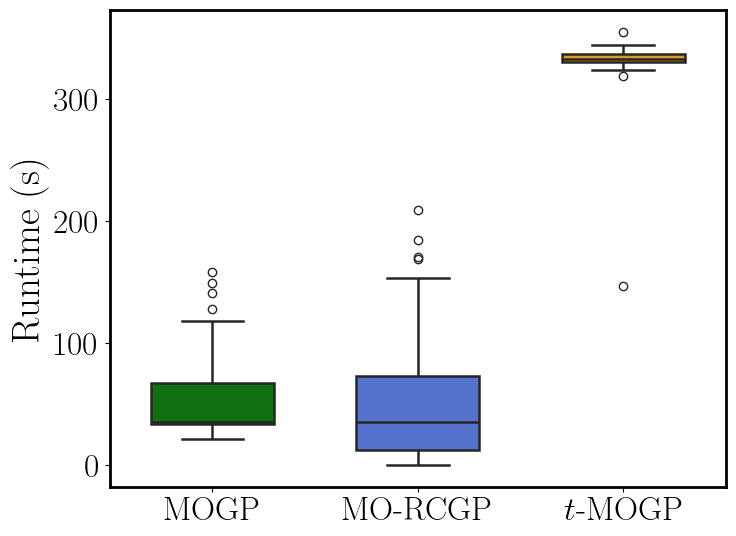

In [15]:
import seaborn as sns

# Combine lists into a list of lists
data = [mogp_all, morcgp_all, tmogp_all]

import seaborn as sns
import matplotlib.pyplot as plt

# Custom colors in required order
colors = ["green", "royalblue", "orange"]

plt.figure(figsize=(8, 6))

# Thicker axes borders
plt.gca().spines["top"].set_linewidth(2)
plt.gca().spines["right"].set_linewidth(2)
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

# Boxplot with thick borders
sns.boxplot(
    data=data,
    palette=colors,
    linewidth=1.8,            # thicker box borders
    width=0.6
)

# Labels
plt.xticks([0, 1, 2], [r'MOGP', r'MO-RCGP', r'$t$-MOGP'])
plt.ylabel(r'Runtime (s)')

plt.tight_layout()
plt.show()


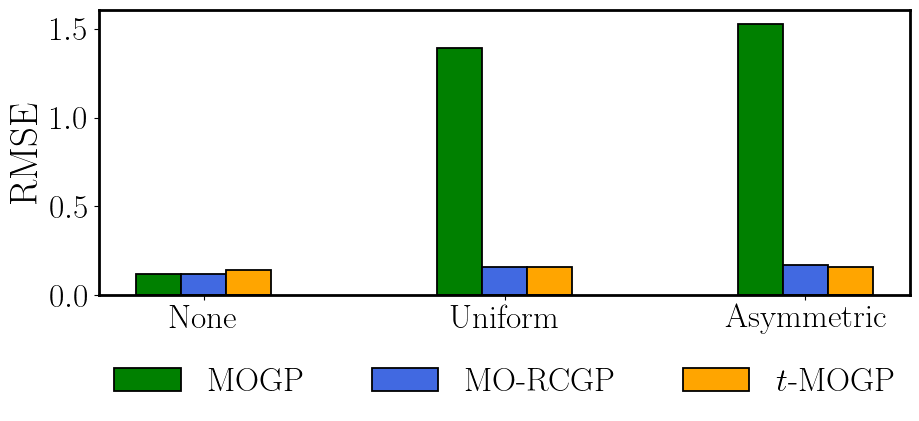

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE values extracted from your table
outlier_types = ["None", "Uniform", "Asymmetric"]

rmse_MOGP     = [0.12, 1.39, 1.53]
rmse_MORCGP   = [0.12, 0.16, 0.17]
rmse_tMOGP    = [0.14, 0.16, 0.16]

x = np.arange(len(outlier_types))
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 5))

# Make the figure border thicker
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Bars with outlines
ax.bar(x - width, rmse_MOGP,    width, label="MOGP",
       color='green', edgecolor='black', linewidth=1.3)
ax.bar(x,         rmse_MORCGP,  width, label="MO-RCGP",
       color='royalblue', edgecolor='black', linewidth=1.3)
ax.bar(x + width, rmse_tMOGP,   width, label=r"$t$-MOGP",
       color='orange', edgecolor='black', linewidth=1.3)

# Labels & formatting
ax.set_ylabel("RMSE")
# ax.set_title("RMSE by Method and Outlier Type")
ax.set_xticks(x)
ax.set_xticklabels(outlier_types)

# Legend below the plot
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np

def decile_quantiles(values):
    """
    Returns the 10%, 20%, ..., 90% quantiles of a list of numbers.
    """
    probs = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.9
    return np.quantile(values, probs)
# print(decile_quantiles(mogp_all))
# print(decile_quantiles(morcgp_all))
print(decile_quantiles(tmogp_all))

[326.47248 329.63544 330.83816 331.7964  333.089   334.42854 336.17286
 337.44748 339.21608]


In [30]:
def boxplot_values(values):
    probs = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
    minimum = np.min(values)
    maximum = np.max(values)
    arr = [minimum] + list(np.quantile(values, probs)) + [maximum]
    return [f"{x:.6f}" for x in arr]
# print(boxplot_values(mogp_all))
print(boxplot_values(morcgp_all))
print(boxplot_values(tmogp_all))

['0.134500', '0.145125', '12.439775', '35.712600', '73.140900', '154.022775', '209.051500']
['147.159400', '325.174505', '330.232475', '333.089000', '336.845575', '341.085615', '355.352800']


# Student-t outliers

In [ ]:
rmses_mogp, rmses_morcgp, rmses_tmogp = [], [], []
nlpds_mogp, nlpds_morcgp, nlpds_tmogp = [], [], []
times_mogp, times_morcgp, times_tmogp = [], [], []

prop_outliers = 0.1
num_seeds = 5

run_mogp = False
run_morcgp = False
run_tmogp = True

for i in tqdm(range(num_seeds)):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=i
    )

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    Y_train_scaled = student_t_outliers(Y=Y_train_scaled, percent_outliers=prop_outliers, df=5, scale=1.0)

    if run_mogp:
        rmse_mogp, nlpd_mogp, time_mogp = run_MOGP_numpy(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers)
        print(f'Student-t outliers: MOGP seed {i}: RMSE = {rmse_mogp}, NLPD = {nlpd_mogp}, Time = {time_mogp}')
        rmses_mogp.append(rmse_mogp)
        nlpds_mogp.append(nlpd_mogp)
        times_mogp.append(time_mogp)
    if run_morcgp:
        rmse_morcgp, nlpd_morcgp, time_morcgp = run_MORCGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, prop_outliers=prop_outliers, k=2)
        print(f'Student-t outliers: MORCGP seed {i}: RMSE = {rmse_morcgp}, NLPD = {nlpd_morcgp}, Time = {time_morcgp}')
        rmses_morcgp.append(rmse_morcgp)
        nlpds_morcgp.append(nlpd_morcgp)
        times_morcgp.append(time_morcgp)
    if run_tmogp:
        rmse_tmogp, nlpd_tmogp, time_tmogp = run_tMOGP(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, df=3)
        print(f'Student-t outliers: t-MOGP seed {i}: RMSE = {rmse_tmogp}, NLPD = {nlpd_tmogp}, Time = {time_tmogp}')
        rmses_tmogp.append(rmse_tmogp)
        nlpds_tmogp.append(nlpd_tmogp)
        times_tmogp.append(time_tmogp)

if run_mogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_mogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_mogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_mogp))
    print(f'RMSE MOGP: {np.mean(rmses_mogp):.4f} ± {np.std(rmses_mogp):.4f}')
    print(f'NLPD MOGP: {np.mean(nlpds_mogp):.4f} ± {np.std(nlpds_mogp):.4f}')
    print(f'Time MOGP: {np.mean(times_mogp):.4f} ± {np.std(times_mogp):.4f}')

if run_morcgp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print("Time:", ", ".join(f"{x:.4f}" for x in rmses_morcgp))
    print(f'RMSE MORCGP: {np.mean(rmses_morcgp):.4f} ± {np.std(rmses_morcgp):.4f}')
    print(f'NLPD MORCGP: {np.mean(nlpds_morcgp):.4f} ± {np.std(nlpds_morcgp):.4f}')
    print(f'Time MORCGP: {np.mean(times_morcgp):.4f} ± {np.std(times_morcgp):.4f}')

if run_tmogp:
    print("RMSE:", ", ".join(f"{x:.4f}" for x in rmses_tmogp))
    print("NLPD:", ", ".join(f"{x:.4f}" for x in nlpds_tmogp))
    print("Time:", ", ".join(f"{x:.4f}" for x in times_tmogp))
    print(f'RMSE t-MOGP: {np.mean(rmses_tmogp):.4f} ± {np.std(rmses_tmogp):.4f}')
    print(f'NLPD t-MOGP: {np.mean(nlpds_tmogp):.4f} ± {np.std(nlpds_tmogp):.4f}')
    print(f'Time t-MOGP: {np.mean(times_tmogp):.4f} ± {np.std(times_tmogp):.4f}')

 20%|██        | 1/5 [06:25<25:43, 385.97s/it]

Student-t outliers: t-MOGP seed 0: RMSE = 0.1467389110638898, NLPD = -0.4381454820961423, Time = 385.83802556991577


 40%|████      | 2/5 [12:30<18:40, 373.45s/it]

Student-t outliers: t-MOGP seed 1: RMSE = 0.17191644676947804, NLPD = -0.3194124634763358, Time = 364.56728315353394


 60%|██████    | 3/5 [18:37<12:21, 370.52s/it]

Student-t outliers: t-MOGP seed 2: RMSE = 0.15574287467677875, NLPD = -0.41419876708980263, Time = 366.9639685153961


 80%|████████  | 4/5 [26:13<06:44, 404.08s/it]

Student-t outliers: t-MOGP seed 3: RMSE = 0.1450338947335473, NLPD = -0.4310896245107469, Time = 455.4786260128021


100%|██████████| 5/5 [34:50<00:00, 418.10s/it]

Student-t outliers: t-MOGP seed 4: RMSE = 0.13605355065955416, NLPD = -0.4867451519818098, Time = 517.1459333896637
RMSE: 0.1467, 0.1719, 0.1557, 0.1450, 0.1361
NLPD: -0.4381, -0.3194, -0.4142, -0.4311, -0.4867
Time: 385.8380, 364.5673, 366.9640, 455.4786, 517.1459
RMSE t-MOGP: 0.1511 ± 0.0121
NLPD t-MOGP: -0.4179 ± 0.0548
Time t-MOGP: 417.9988 ± 59.5461
